In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error    # this is easier to explain to a non-tech. audience than r2
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from ipywidgets import *
from IPython.display import display
import seaborn as sns

In [2]:
train = pd.read_csv('datasets/train.csv', keep_default_na=False, na_values=[''])
train.isnull().sum().sort_values(ascending=False).head(10)
test = pd.read_csv('datasets//test.csv')
sample = pd.read_csv('datasets//sample_sub_reg.csv')

# EDA AND DATA CLEANING

Below we set the baseline score, which in this case is the average sale price of houses sold. It acts
as a bench mark against predictions made.

In [3]:
train['baseline'] = train['SalePrice'].mean()

In [4]:
train['Bldg Type'].unique()

array(['1Fam', 'TwnhsE', 'Twnhs', '2fmCon', 'Duplex'], dtype=object)

In [5]:
train = train.loc[train['Bldg Type'] == '1Fam']

In [6]:
train.shape

(1700, 82)

In [7]:
train = train[train['Gr Liv Area'] < 4000]

In [8]:
train.shape

(1698, 82)

In [9]:
# train.info()

In [10]:
train.isnull().sum()

Id                0
PID               0
MS SubClass       0
MS Zoning         0
Lot Frontage    285
               ... 
Mo Sold           0
Yr Sold           0
Sale Type         0
SalePrice         0
baseline          0
Length: 82, dtype: int64

In [11]:
train.dtypes

Id                int64
PID               int64
MS SubClass       int64
MS Zoning        object
Lot Frontage    float64
                 ...   
Mo Sold           int64
Yr Sold           int64
Sale Type        object
SalePrice         int64
baseline        float64
Length: 82, dtype: object

In [12]:
train.columns = [col.replace(' ', '_') for col in train.columns]

In [13]:
train.columns = train.columns.str.lower()

In [14]:
train.rename(columns={'saleprice': 'sale_price'}, inplace=True)

#### Looked at correlation of total baths to sale price, but decided not to use that feature

In [15]:
train['total_bath'] = train['full_bath'] + train['half_bath']

#### Looked at correlation of central air to sale price, but decided not to use that feature

In [16]:
train.central_air = train.central_air.apply(lambda x: 0 if x.strip()=='N' else 1)

In [17]:
train.central_air.unique()

array([1, 0], dtype=int64)

In [18]:
features = [
    'gr_liv_area', 
    'overall_qual', 
    'year_built',
    'ms_zoning'
]

In [19]:
train[features].isnull().sum()

gr_liv_area     0
overall_qual    0
year_built      0
ms_zoning       0
dtype: int64

In [20]:
X = train[features]
y = train['sale_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### Filling Missing Values

In [21]:
# all features used had 0 missing values, so didn't fill values
# would have used:

# train['column'].fillna(0, inplace=True)

# OR

# si = SimpleImputer()

# si.fit(X_train[['column']])

# X_train['column'] = si.transform(X_train[['column']])
# X_test['column'] = si.transform(X_test[['column']])

## First Visual
- *put this here to capture this plot before data is changed

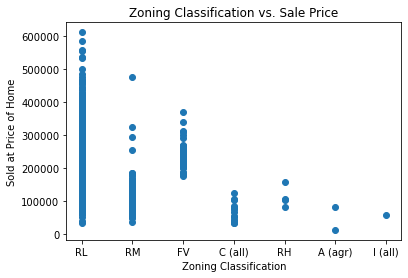

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X_train.ms_zoning, y_train)

ax.set_xlabel('Zoning Classification')
ax.set_ylabel('Sold at Price of Home')
ax.set_title('Zoning Classification vs. Sale Price');

#### Encoding Categorical Features

In [23]:
X_train.ms_zoning.value_counts()

RL         1057
RM          157
FV           39
C (all)      13
RH            4
A (agr)       2
I (all)       1
Name: ms_zoning, dtype: int64

In [24]:
X_train['ms_zoning'].unique(), X_test['ms_zoning'].unique()

(array(['RL', 'RM', 'FV', 'C (all)', 'RH', 'A (agr)', 'I (all)'],
       dtype=object),
 array(['RL', 'RM', 'FV', 'C (all)', 'RH'], dtype=object))

In [25]:
X_train.dtypes

gr_liv_area      int64
overall_qual     int64
year_built       int64
ms_zoning       object
dtype: object

In [26]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train[['ms_zoning']])

OneHotEncoder(handle_unknown='ignore')

In [27]:
ohe.get_feature_names_out()

array(['ms_zoning_A (agr)', 'ms_zoning_C (all)', 'ms_zoning_FV',
       'ms_zoning_I (all)', 'ms_zoning_RH', 'ms_zoning_RL',
       'ms_zoning_RM'], dtype=object)

In [28]:
train_ohe = pd.DataFrame(
    ohe.transform(X_train[['ms_zoning']]).todense(),
    columns = ohe.get_feature_names_out(),
    index = X_train.index
)

train_ohe.head(3)

,ms_zoning_A (agr),ms_zoning_C (all),ms_zoning_FV,ms_zoning_I (all),ms_zoning_RH,ms_zoning_RL,ms_zoning_RM
256,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1360,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1717,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [29]:
test_ohe = pd.DataFrame(
    ohe.transform(X_test[['ms_zoning']]).todense(),
    columns = ohe.get_feature_names_out(),
    index = X_test.index
)

In [30]:
X_train = pd.concat(
    [X_train.drop(columns=['ms_zoning']), train_ohe],
    axis=1
)

X_train.head(3)

,gr_liv_area,overall_qual,year_built,ms_zoning_A (agr),ms_zoning_C (all),ms_zoning_FV,ms_zoning_I (all),ms_zoning_RH,ms_zoning_RL,ms_zoning_RM
256,1124,5,1954,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1360,2009,6,1928,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1717,1934,5,1977,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [31]:
X_test = pd.concat(
    [X_test.drop(columns=['ms_zoning']), test_ohe],
    axis=1
)

In [32]:
X_test.head(3)

,gr_liv_area,overall_qual,year_built,ms_zoning_A (agr),ms_zoning_C (all),ms_zoning_FV,ms_zoning_I (all),ms_zoning_RH,ms_zoning_RL,ms_zoning_RM
757,1253,6,1960,0.0,0.0,0.0,0.0,0.0,1.0,0.0
146,1922,7,2003,0.0,0.0,0.0,0.0,0.0,1.0,0.0
173,1644,5,1942,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Scaling

In [33]:
ss = StandardScaler()
print(ss.fit(X_train))

StandardScaler()


In [34]:
X_train = pd.DataFrame(ss.transform(X_train), columns=X_train.columns)

In [35]:
ss = StandardScaler()
print(ss.fit(X_test))

StandardScaler()


In [36]:
X_test = pd.DataFrame(ss.transform(X_test), columns=X_test.columns)

# Modeling

## Linear Regression

In [37]:
len(train_test_split(X, y,
                train_size=0.8, 
                random_state=123))

4

In [38]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)

y_pred = mlr.predict(X_test)

print('MLR score:', mlr.score(X_train, y_train), mlr.score(X_test, y_test))
print('MLR intercept:', mlr.intercept_)
print('MLR coeffs:', mlr.coef_)

MLR score: 0.8004366148902161 0.7611580407516053
MLR intercept: 183157.90887666927
MLR coeffs: [33264.37266593 35769.42383236 13869.76959958  1022.8970655
   458.04035858   227.7421462   1486.78106151   -86.06879426
  1651.98932707 -2380.41901956]


In [39]:
mlr.score(X_train, y_train), mlr.score(X_test, y_test)

(0.8004366148902161, 0.7611580407516053)

In [40]:
def rmse(model, X, y):
    model_preds = model.predict(X)
    return mean_squared_error(y, model_preds, squared=False)

In [41]:
rmse(mlr, X_train, y_train), rmse(mlr, X_test, y_test)

(35563.740447115466, 43116.19988453238)

In [42]:
cross_val_score(mlr, X_train, y_train)

array([0.77494964, 0.8055612 , 0.80516578, 0.79348939, 0.80489665])

# Lasso

In [43]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [44]:
lasso = Lasso(alpha=100)
lasso.fit(X_train_ss, y_train)

Lasso(alpha=100)

In [45]:
print(lasso.score(X_train_ss, y_train), lasso.score(X_test_ss, y_test))
rmse(lasso, X_train_ss, y_train), rmse(lasso, X_test_ss, y_test)

0.8004243370564069 0.7607969042182589


(35564.834432815354, 43148.7840953517)

In [46]:
cross_val_score(mlr, X_train_ss, y_train)

array([0.77494964, 0.8055612 , 0.80516578, 0.79348939, 0.80489665])

# Ridge

In [47]:
ridge = Ridge(alpha=100)
ridge.fit(X_train_ss, y_train)

Ridge(alpha=100)

In [48]:
print(ridge.score(X_train_ss, y_train), ridge.score(X_test_ss, y_test))
rmse(ridge, X_train_ss, y_train), rmse(ridge, X_test_ss, y_test)

0.7990385624254621 0.7562499363939346


(35688.094921342214, 43556.95717079978)

In [49]:
cross_val_score(mlr, X_train_ss, y_train)

array([0.77494964, 0.8055612 , 0.80516578, 0.79348939, 0.80489665])

# Visuals

In [50]:
# Set size of visuals from below link:
# https://stackoverflow.com/questions/31594549/how-to-change-the-figure-size-of-a-seaborn-axes-or-figure-level-plot

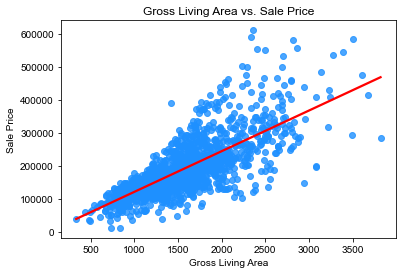

In [51]:
ax = sns.regplot(x = 'gr_liv_area',
            y = 'sale_price', 
            ci = None,
            data = train,
            scatter_kws={"color": "dodgerblue"}, line_kws={"color": "red"})
ax.set(xlabel='Gross Living Area',
       ylabel='Sale Price',
       title='Gross Living Area vs. Sale Price');

sns.set(rc={'figure.figsize':(6,4)})

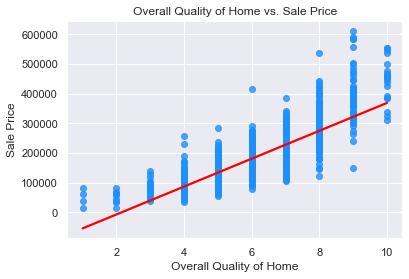

In [52]:
ax = sns.regplot(x = 'overall_qual',
            y = 'sale_price', 
            ci = None,
            data = train,
            scatter_kws={"color": "dodgerblue"}, line_kws={"color": "red"})
ax.set(xlabel='Overall Quality of Home',
       ylabel='Sale Price',
       title='Overall Quality of Home vs. Sale Price');

sns.set(rc={'figure.figsize':(6,4)})

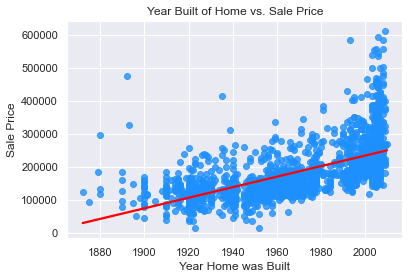

In [53]:
ax = sns.regplot(x = 'year_built',
            y = 'sale_price', 
            ci = None,
            data = train,
            scatter_kws={"color": "dodgerblue"}, line_kws={"color": "red"})
ax.set(xlabel='Year Home was Built',
       ylabel='Sale Price',
       title='Year Built of Home vs. Sale Price');

sns.set(rc={'figure.figsize':(6,4)})